In [13]:
import json 
import os.path
import matplotlib.pyplot as plt
from types import SimpleNamespace

INITIAL_NUM_ZOMBIE_CHANNELS = 57000
LN_CLOSING_CHANNEL_DELAY = 1000 # ~ 1 week

accumulated_txs = 0 # transactions that would have been already confirmed without the zombie channels transactions

blocks_file = open(f"blocks/blocks.json", mode = 'r')
blocks_data_content = blocks_file.read()
blocks_data = json.loads(blocks_data_content)

# We read the file containing mempool historical data

i = 1
mempool_data_json_string = ''

while os.path.exists(f"mempool/{i}_mempool"):
    mempool_data_file = open(f"mempool/{i}_mempool", mode = 'r')
    mempool_data_content = mempool_data_file.read()
    
    # We replace call() from file content (it is used for the website to load the JSONP)
    mempool_data_content = mempool_data_content[5 : len(mempool_data_content) - 2]
    
    # I remove the first and the last square brackets, then I will add them again at the end before parsing the JSON,
    # in order to obtain a single merged json of all the mempool data
    mempool_data_content = mempool_data_content[1:]
    mempool_data_content = mempool_data_content[:-1]

    mempool_data_content += ','

    mempool_data_json_string += mempool_data_content
    mempool_data_file.close()

    i += 1

mempool_data_json_string = mempool_data_json_string[:-1]
mempool_data_json_string = f"[{mempool_data_json_string}]"

# Parsing JSON file

mempool_data = json.loads(mempool_data_json_string) 

In [14]:
# Data taken from https://jochen-hoenicke.de/queue/#BTC,all,count

PROBLEMATIC_INTERVALS = [[1516728783, 1516729440], [1515943500, 1515944160]] # problematic intervals that should not be considerated (probably the BTC nodes of the owner went offline for a while)

fee_ranges = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200, 250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1700, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 10000 ]

def find_index_of_fee_in_ranges(fee):
    fee_index = 0

    i = 1

    while i < len(fee_ranges):
        if fee_ranges[i-1] <= fee and fee < fee_ranges[i]:
            fee_index = i-1
            return fee_index
        i = i + 1

    return fee_ranges[len(fee_ranges) - 1] # maximum fee index

def getAverageFeeIndex(tx_count_per_fee_level):
    
    total_tx_count = sum(tx_count_per_fee_level)

    acc = 0
    i = 0

    while(i < len(tx_count_per_fee_level)):
        acc = acc + (fee_ranges[i] * tx_count_per_fee_level[i])
        i = i + 1

    avg_fee = acc / total_tx_count

    average_index = find_index_of_fee_in_ranges(avg_fee)
    
    return average_index

def get_median_index_fee(tx_count_per_fee_level):

    total_tx_count = sum(tx_count_per_fee_level)

    # Computing the index of the median fee in `fee_ranges` (in the first snapshot of the simulation)

    acc = 0
    i = 0
    median_index = 0

    for c in tx_count_per_fee_level:
        acc = acc + c
        if acc >= total_tx_count / 2:
            # As soon as we detected that half of all the txs in the mempool have a lower fee 
            # than the current fee index (and half have an higher fee), than this is the median fee index
            median_index = i
            break
        else:
            i = i + 1  

    return median_index    

def isInProblematicInterval(timestamp, PROBLEMATIC_INTERVALS):
    for interval in PROBLEMATIC_INTERVALS:
        if(timestamp >= interval[0] and timestamp < interval[1]):
            return True
    return False

def decreaseTxWithSameFee(fee_index, ln_txs_per_fee_level, tx_to_be_added, amount):
    
    tx_to_be_added[fee_index] = max(tx_to_be_added[fee_index] - amount, 0)

    for tx in ln_txs_per_fee_level[fee_index]:
        tx.tx_with_same_fee = max(tx.tx_with_same_fee - amount, 0)
    
def getFullTxCountPerFeeLevel(tx_count_per_fee_level, ln_txs_per_fee_level, tx_to_be_added, remaining_attacker_txs):
    full_tx_count_per_fee_level = [0] * len(fee_ranges)

    for i in range(len(fee_ranges)):
        full_tx_count_per_fee_level[i] += tx_count_per_fee_level[i] + tx_to_be_added[i]

        if(len(ln_txs_per_fee_level[i]) > 0):
            if(ln_txs_per_fee_level[i][0].isAttacker):
                full_tx_count_per_fee_level[i] += remaining_attacker_txs + (len(ln_txs_per_fee_level[i]) - 1)
            else:
                full_tx_count_per_fee_level[i] += len(ln_txs_per_fee_level[i])
    return full_tx_count_per_fee_level
            
def find_txs_to_be_added(starting_fee_index, amount, last_tx_count_per_fee_level, tx_to_be_added):
    index = starting_fee_index
    while(amount > 0 and index >= 0):
        if(last_tx_count_per_fee_level[index] >= amount):
            tx_to_be_added[index] += amount
            amount = 0
        else:
            tx_to_be_added[index] += last_tx_count_per_fee_level[index]
            amount -= last_tx_count_per_fee_level[index]
        index -= 1

# There will be num_zombie_channels * 2 transactions  (both from the attacker and from the victims to dispute )
def simulate(mempool_data, blocks_data, first_block_height, fee_index_attacker, num_channels, highest_priority=False, dynamic=False, alpha=0.5, beta=1, step=1):
    
    first_height = blocks_data[0]["height"] # First Block Height in our dataset
    blocksCounter = 0
    last_total_tx_count = None
    last_tx_count_per_fee_level = None
    remaining_attacker_txs = num_channels # Attacker txs that are still unconfirmed
    num_confirmed_victim_transactions = 0

    victim_index = 0 # Index in the `transactions` array
    transactions = []  # Array of SimpleNamespace (JavaScript-like objects): contains all the LN victim transactions

    for i in range(0, num_channels):
        transaction = SimpleNamespace()
        transaction.submitted = False
        transaction.confirmed = False
        transaction.confirmedBlockNumber = -1
        transaction.attackerTxConfirmedBlockNumber = -1
        transaction.fee_index = -1
        transaction.tx_with_same_fee = -1 # Transactions already present in the mempool with the same fee level
        transaction.isAttacker = False
        transactions.append(transaction) 
    
    # For each LN tx, we associate the "position" among the other txs with the same fee (how many transactions with the same fee were already in the mempool when the tx was inserted)
    ln_txs_per_fee_level = []  
    for i in range(len(fee_ranges)):
        empty_array = []
        ln_txs_per_fee_level.append(empty_array)
    
    # When we confirm any LN tx, it means that it "replaces" a transaction that was historically confirmed, and thus removed
    # from the mempool. Therefore, we must keep track and include them in a later block.
    tx_to_be_added = [0] * len(fee_ranges) 

    for snapshot in mempool_data:
        timestamp = snapshot[0]
        tx_count_per_fee_level = snapshot[1]
        
        total_tx_count = sum(tx_count_per_fee_level)

        if last_total_tx_count is None and last_tx_count_per_fee_level is None:
            last_total_tx_count = total_tx_count
            last_tx_count_per_fee_level = tx_count_per_fee_level

            initial_tx_with_same_fee_attacker = tx_count_per_fee_level[fee_index_attacker]

            attackerTx = SimpleNamespace()
            attackerTx.fee_index = fee_index_attacker
            attackerTx.tx_with_same_fee = initial_tx_with_same_fee_attacker
            attackerTx.isAttacker = True 
            attackerTx.confirmed = False 

            ln_txs_per_fee_level[fee_index_attacker].append(attackerTx)

            continue
        
        # "Problematic" intervals are intervals in which probably the node of the owner of the website that gives the dataset
        # went offline for sometime
        is_in_problematic_interval = isInProblematicInterval(timestamp, PROBLEMATIC_INTERVALS)

        if total_tx_count < last_total_tx_count and not is_in_problematic_interval:
            # New Block

            # On new block, we compute the number of transactions with a fee that is higher than LN txs
            # If this number is higher than the number of transactions in the block, no LN txs are confirmed in this block.
            # Otherwise, some LN txs could be included in the block, and we must check their current "position" in the mempool
            # at their fee level, i.e. how many txs there are in the same fee level that were submitted before them.

            blocksCounter += 1
            
            num_tx_in_block = blocks_data[(first_block_height - first_height + blocksCounter) - 1]["n_transactions"]
            
            # As said before, LN txs actually "replace" standard txs that would have been removed from the mempool
            # without LN txs, therefore they must be re-added and considered for future blocks.
            amount_tx_to_be_added = 0
            starting_index_tx_to_be_added = 0

            # We find the higher fee in LN transactions
            highest_ln_fee_index = 0
            i = len(fee_ranges) - 1

            while(i >= 0):
                if(len(ln_txs_per_fee_level[i]) > 0):
                    highest_ln_fee_index = i
                    break
                i -= 1

            index = len(last_tx_count_per_fee_level) - 1
            
            tx_with_higher_fee = 0

            # Now we confirm transactions that have an higher fee than our LN txs
            while index > highest_ln_fee_index and tx_with_higher_fee < num_tx_in_block:
                tmp = tx_with_higher_fee
                tx_with_higher_fee = tx_with_higher_fee + last_tx_count_per_fee_level[index] + tx_to_be_added[index]

                # Here we don't call decreaseTxWithSameFee because there are no LN txs in this fee level
                # by construction (fee_index > highest_ln_fee_index)

                tx_to_be_added[index] = max(tx_to_be_added[index] - (num_tx_in_block - tmp), 0) # (num_tx_in_block - tmp) is the number of txs with this fee level included in this block   
                index -= 1

            tx_to_be_confirmed = num_tx_in_block - tx_with_higher_fee

            if(tx_to_be_confirmed > 0):

                # There is still "space" for more transactions in the block
            
                fee_index = highest_ln_fee_index
                
                while(fee_index >= 0 and tx_to_be_confirmed > 0):
                    
                    ln_txs = ln_txs_per_fee_level[fee_index]

                    if(len(ln_txs) > 0): # If there are LN txs in this fee level
                        tx_index = 0

                        while tx_index < len(ln_txs):
                            tx = ln_txs_per_fee_level[fee_index][tx_index]

                            if(not tx.isAttacker and tx.attackerTxConfirmedBlockNumber == blocksCounter):
                                # The corresponding attacker tx was confirmed in this block, therefore we cannot
                                # confirm this victim tx in this fee level
                                tx_index += 1
                                continue
                            
                            # The "position" of txs in the mempool is modified
                            if(tx.tx_with_same_fee >= tx_to_be_confirmed):
                                decreaseTxWithSameFee(fee_index, ln_txs_per_fee_level, tx_to_be_added, tx_to_be_confirmed)
                                tx_to_be_confirmed = 0
                            else:
                                if(tx.tx_with_same_fee > 0):
                                    tx_to_be_confirmed -= tx.tx_with_same_fee
                                    decreaseTxWithSameFee(fee_index, ln_txs_per_fee_level, tx_to_be_added, tx.tx_with_same_fee)
                            
                            if(tx_to_be_confirmed == 0):
                                break

                            if(tx.isAttacker):
                                tmp = remaining_attacker_txs
                                remaining_attacker_txs = max(remaining_attacker_txs - tx_to_be_confirmed, 0)
                                num_attacker_confirmed_txs = tmp - remaining_attacker_txs
                                tx_to_be_confirmed -= num_attacker_confirmed_txs

                                amount_tx_to_be_added += num_attacker_confirmed_txs
                                starting_index_tx_to_be_added = fee_index

                                new_victim_index = victim_index + num_attacker_confirmed_txs

                                while(victim_index < new_victim_index):
                                    transactions[victim_index].submitted = True
                                    victim_fee_index = getAverageFeeIndex(getFullTxCountPerFeeLevel(tx_count_per_fee_level, ln_txs_per_fee_level, tx_to_be_added, remaining_attacker_txs)) # average or median
                                    transactions[victim_index].fee_index = victim_fee_index
                                    transactions[victim_index].tx_with_same_fee = tx_count_per_fee_level[victim_fee_index] + tx_to_be_added[victim_fee_index] 
                                    transactions[victim_index].attackerTxConfirmedBlockNumber = blocksCounter
                                    ln_txs_per_fee_level[victim_fee_index].append(transactions[victim_index])
                                    victim_index += 1

                                if(remaining_attacker_txs == 0):
                                    print("Finished mining attacker txs at block:", blocksCounter)
                                    del ln_txs_per_fee_level[fee_index][tx_index]
                            else:
                                tx.confirmed = True
                                tx.confirmedBlockNumber = blocksCounter
                                tx_to_be_confirmed -= 1
                                num_confirmed_victim_transactions += 1   
                            
                                del ln_txs_per_fee_level[fee_index][tx_index]

                                amount_tx_to_be_added += 1
                                starting_index_tx_to_be_added = fee_index

                            tx_index += 1

                    else:
                        tmp = tx_to_be_confirmed
                        tx_to_be_confirmed = max(tx_to_be_confirmed - tx_to_be_added[fee_index], 0)
                        tx_to_be_added[fee_index] = max(tx_to_be_added[fee_index] - (tmp - tx_to_be_confirmed), 0)
                        tx_to_be_confirmed = max(tx_to_be_confirmed - last_tx_count_per_fee_level[fee_index], 0)
                    
                    fee_index -= 1

            # If there are some `tx_to_be_added` to add, they are added to the corresponding fee_level in the array
            find_txs_to_be_added(starting_index_tx_to_be_added, amount_tx_to_be_added, last_tx_count_per_fee_level, tx_to_be_added)

        if(num_confirmed_victim_transactions >= num_channels):
            print("Finished at block ", blocksCounter)

            channels_not_able_to_close = 0
            for tx in transactions:
                #if(not tx.isAttacker):
                    #print(tx.confirmedBlockNumber - tx.attackerTxConfirmedBlockNumber)
                if(not tx.isAttacker and (tx.confirmedBlockNumber - tx.attackerTxConfirmedBlockNumber) > LN_CLOSING_CHANNEL_DELAY):
                    channels_not_able_to_close += 1
            print("Channels not able to close in time: ", channels_not_able_to_close)
            return channels_not_able_to_close

        last_total_tx_count = total_tx_count
        last_tx_count_per_fee_level = tx_count_per_fee_level
    
    print("Not able to finish")
    return None

Finished mining attacker txs at block: 7612
Finished at block  7940
Channels not able to close in time:  0
Finished mining attacker txs at block: 7572
Finished at block  7886
Channels not able to close in time:  231
Finished mining attacker txs at block: 7518
Finished at block  7799
Channels not able to close in time:  1493
Finished mining attacker txs at block: 7276
Finished at block  7656
Channels not able to close in time:  1497
Finished mining attacker txs at block: 7054
Finished at block  7622
Channels not able to close in time:  5056
Finished mining attacker txs at block: 6959
Finished at block  7517
Channels not able to close in time:  38706
Finished mining attacker txs at block: 3935
Finished at block  7313
Channels not able to close in time:  57000
Finished mining attacker txs at block: 3853
Finished at block  7289
Channels not able to close in time:  57000
Finished mining attacker txs at block: 1597
Finished at block  7049
Channels not able to close in time:  57000
Finished m

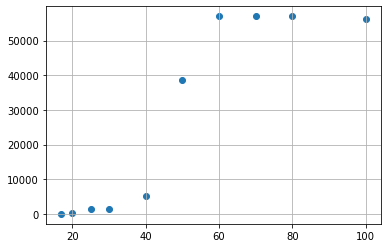

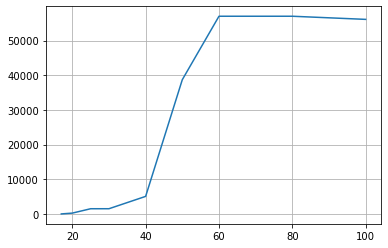

In [15]:
y = []
x = []

#simulate(mempool_data, blocks_data, 497928, 17, INITIAL_NUM_ZOMBIE_CHANNELS)

i = 12
fee_ranges2 = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100 ]
while(i < len(fee_ranges2)):
    n = simulate(mempool_data, blocks_data, 497928, i, INITIAL_NUM_ZOMBIE_CHANNELS)
    y.append(n)
    x.append(fee_ranges2[i])
    i += 1

fig, ax = plt.subplots()
ax.grid(True)
plt.scatter(x, y)
plt.show() 

fig, ax = plt.subplots()
ax.grid(True)
plt.plot(x, y)
plt.show()